In [9]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [11]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,4.794195,-8.249228,-9.894946,-5.896336,0.786684,5.269970
1,-0.641768,-9.602808,14.231035,0.573691,0.052295,1.060287
2,2.612563,-11.385828,-12.903688,-0.402864,9.754886,0.731949
3,1.384545,17.906736,-4.959831,-6.789407,-3.877294,-2.255584
4,-4.220795,-6.356165,-3.674784,14.070560,-2.290916,3.999891


In [12]:
# min-max normalization
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [13]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.318084,0.035637,0.000000,0.086587,0.231304,0.328387,0.328387,5,Walking,Walking
1,0.141588,0.000000,0.376584,0.160793,0.152554,0.168481,0.376584,2,Sitting,Sitting
2,0.235705,0.023058,0.000000,0.189898,0.344203,0.207137,0.344203,4,Upstairs,Upstairs
3,0.193946,0.585972,0.043411,0.000000,0.069096,0.107575,0.585972,1,Jogging,Jogging
4,0.053835,0.000000,0.067601,0.514984,0.102490,0.261089,0.514984,3,Standing,Standing
5,0.143152,0.014476,0.000000,0.070331,0.167683,0.604358,0.604358,5,Walking,Walking
6,0.423367,0.000000,0.055933,0.108669,0.240015,0.172016,0.423367,0,Downstairs,Downstairs
7,0.381987,0.000000,0.072492,0.136121,0.225866,0.183534,0.381987,0,Downstairs,Downstairs
8,0.105176,0.538047,0.061452,0.023592,0.000000,0.271733,0.538047,1,Jogging,Jogging
9,0.146602,0.071454,0.031110,0.142391,0.000000,0.608443,0.608443,5,Walking,Walking


Accuracy:  0.9603010804904698


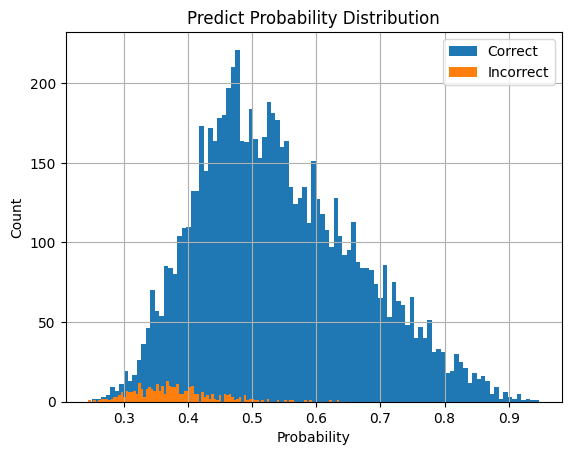

In [14]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [15]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.535520
std       0.125796
min       0.244285
max       0.947521
median    0.520768
Name: predict_probability, dtype: float64

In [26]:
thresholds = [0, 0.3, 0.4, 0.5, 0.6, 0.7]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    cm_labels = LABELS[:len(cm)]
    cm_df = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
    sns.heatmap(
        cm_df,
        annot=True,
        fmt="d",
        linewidths=0.5,
        cmap="Blues",
        cbar=False,
        annot_kws={"size": 14},
        square=True,
    )
    plt.title(f"Confusion Matrix (threshold={threshold})")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    if threshold == 0:
        plt.savefig(f'confusion_matrix/original.png')
    else:
        plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_10168/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.960301,1.000000,0.000000,0.000000
0.3,0.963394,0.991623,0.594203,0.008377
0.4,0.985672,0.864271,0.798748,0.135729
0.5,0.996735,0.557727,0.914356,0.442273
0.6,0.999166,0.291004,0.944349,0.708996
0.7,1.000000,0.119340,0.954921,0.880660
